In [3]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')
#general purpose packages

# nlp
from bs4 import BeautifulSoup
import nltk,string
import re
from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer     # parsing/stemmer
from nltk.tag import pos_tag            # parts-of-speech tagging
from nltk.corpus import wordnet         # sentiment scores
from nltk.stem import WordNetLemmatizer # stem and context
from nltk.corpus import stopwords       # stopwords
from nltk.util import ngrams            # ngram iterator
from nltk.tokenize import word_tokenize

# import word2vec|
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import Word2Vec

# import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
#load data
train_data = pd.read_csv('C:/Users/whtwht97/Desktop/Document/UChicago/Q2 - Health Analytics/final proj/drugsComTrain_raw.csv')
test_data = pd.read_csv('C:/Users/whtwht97/Desktop/Document/UChicago/Q2 - Health Analytics/final proj/drugsComTest_raw.csv')
df = pd.concat([train_data,test_data])
df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


In [5]:
df.drop_duplicates(subset=["review"],inplace=True)

In [6]:
#create sentiment labels
df["sentiment"] = np.where(df["rating"] > 7, 1, np.where(df["rating"] < 4, -1, 0))

In [7]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

def review_cleaner(review, lemmatize=True, stem=False):
    '''
        Clean and preprocess a review.
            1. Remove HTML tags
            2. Extract emoticons
            3. Use regex to remove all special characters (only keep letters)
            4. Make strings to lower case and tokenize / word split reviews
            5. Remove English stopwords
            6. Lemmatize
            7. Rejoin to one string
        
        @review (type:str) is an unprocessed review string
        @return (type:str) is a 6-step preprocessed review string
    '''
    if lemmatize == True and stem == True:
        raise RuntimeError("May not pass both lemmatize and stem flags")

    #1. Remove HTML tags
    review = BeautifulSoup(review, "lxml").text

    #2. Use regex to find emoticons
    pattern2 ='(?::|;|=)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(pattern2,review)

    #3. Remove punctuation
    pattern3 = r"[^\w+ \d+]"
    review = re.sub(pattern3, "",review)

    #4. Tokenize into words (all lower case)
    review = review.lower()

    #5/6. Remove stopwords, Lemmatize, Stem
    word_tokens = word_tokenize(review)
    filtered_sentence = [w for w in word_tokens if not w in eng_stopwords]
    filtered_sentence = []
    for w in word_tokens:
         if w not in eng_stopwords:               
                w = wnl.lemmatize(w)              
                filtered_sentence.append(w)
                  
    #7. Join the review to one sentence
    filtered_sentence = " ".join(filtered_sentence+emoticons)        
    
    return filtered_sentence

In [8]:
df["review"] = df["review"].apply(review_cleaner)

In [9]:
result = []
for text in df.review:
        temp = len(text.split())
        result.append(temp)
        
df["text_len"] = result
df["text_len"].mean()

43.101791746446864

In [10]:
df = df[df["text_len"]<=150]

In [11]:
test_data = df[df.uniqueID.isin(test_data["uniqueID"].values)].reset_index(drop=True)
train_data = df[df.uniqueID.isin(train_data["uniqueID"].values)].reset_index(drop=True)

In [12]:
#assign x and y
train_x = train_data["review"]
test_x = test_data["review"]
train_y = train_data["sentiment"]
test_y = test_data["sentiment"]

In [100]:
vect = CountVectorizer()
nb = MultinomialNB(fit_prior=False)
pipe = Pipeline(steps=[("vectorizer", vect), ("naivebayes", nb)])
param_grid = {"vectorizer__ngram_range": [(1,2),(1,3),(1,4)],
              "vectorizer__max_df": [0.8,0.9,1.0],
              "naivebayes__alpha": [0.01, 0.1, 1.0]}

start = time.time()
search = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
search.fit(train_x, train_y)
print(f"\n... search took {time.time() - start} seconds")

Fitting 3 folds for each of 27 candidates, totalling 81 fits

... search took 2943.8765783309937 seconds


In [101]:
search.best_params_

{'naivebayes__alpha': 0.1,
 'vectorizer__max_df': 0.8,
 'vectorizer__ngram_range': (1, 4)}

In [13]:
# CountVectorizer fit and transform
clf = CountVectorizer(ngram_range=(1,4),max_df=0.8)
X_train_cv =  clf.fit_transform(train_x)
X_test_cv = clf.transform(test_x)

In [133]:
#from imblearn.over_sampling import SMOTE
#train_x_os, train_y_os = SMOTE().fit_resample(X_train_cv, train_y)

In [14]:
# Naive Bayes
nb_clf = MultinomialNB(fit_prior=False,alpha = 0.1)
nb_clf.fit(X_train_cv, train_y)
nb_pred = nb_clf.predict(X_test_cv)

In [15]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(test_y,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.67      0.57      0.61      3539
     Neutral       0.39      0.20      0.26      2819
    Positive       0.76      0.91      0.83      9780

    accuracy                           0.71     16138
   macro avg       0.61      0.56      0.57     16138
weighted avg       0.67      0.71      0.68     16138



In [16]:
accuracy_score(nb_pred, test_y)

0.7091337216507622

In [17]:
cm = confusion_matrix(nb_pred, test_y)

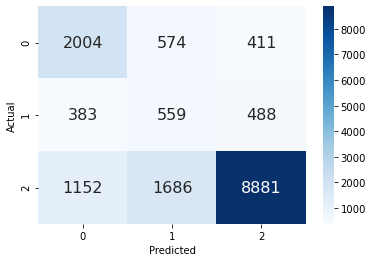

In [18]:
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [32]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(test_y, nb_pred, pos_label = 1)
auc(fpr, tpr)

0.7378583958763125